In [4]:
# Cell 1: Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

In [5]:
# Cell 2: 🔧 FIXED - Enhanced FeaturePreparation Class and Load Preprocessed Data
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 🔧 UPDATED FeaturePreparation class to match the FIXED preprocessing
class FeaturePreparation:
    def __init__(self, scale_target=False):  # 🔧 FIXED: Target scaling disabled
        """
        Enhanced Feature Preparation matching the FIXED preprocessing pipeline.

        Args:
            scale_target: Whether to scale target variable (DISABLED to prevent negative values)
        """
        # Updated parameter from 'sparse' to 'sparse_output'
        self.main_category_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.sub_category_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.numeric_scaler = StandardScaler()

        # 🔧 CRITICAL FIX: Target scaler conditionally initialized
        self.scale_target = scale_target
        self.target_scaler = StandardScaler() if scale_target else None

        self.fitted = False
        self.target_fitted = False

        # Enhanced statistics storage for debugging
        self.original_target_stats = {}
        self.log_transformed_stats = {}
        self.scaled_target_stats = {}
        self.transformation_metadata = {
            'target_scaling_enabled': scale_target,
            'fix_applied': 'Disabled target scaling to prevent negative values',
            'reason': 'StandardScaler after log transform creates negative values that break inverse transform'
        }

    def fit(self, df):
        """Fit encoders and scalers to the data."""
        print("Fitting category encoders and numeric scaler...")
        self.main_category_encoder.fit(df[['main_category']])
        self.sub_category_encoder.fit(df[['sub_category']])

        numeric_features = ['discount_price', 'actual_price', 'discount_ratio',
                            'popularity', 'ratings', 'log_no_of_ratings']
        self.numeric_scaler.fit(df[numeric_features])
        self.fitted = True
        print("✅ Feature fitting complete!")
        return self

    def fit_target(self, y):
        """Fit target scaler with proper validation."""
        print(f"\n=== Target Processing (Scale Target: {self.scale_target}) ===")
        print(f"Input range: {np.min(y):.4f} to {np.max(y):.4f}")

        if self.scale_target and self.target_scaler is not None:
            # Fit the scaler only if enabled
            self.target_scaler.fit(y.reshape(-1, 1))
            print(f"✅ Target scaler fitted!")
        else:
            print(f"🔧 Target scaling DISABLED - using log-transformed values directly")

        self.target_fitted = True
        return self

    def transform_target(self, y):
        """Transform target variable with validation."""
        if not self.target_fitted:
            raise ValueError("Target scaler is not fitted yet.")

        if self.scale_target and self.target_scaler is not None:
            y_transformed = self.target_scaler.transform(y.reshape(-1, 1)).flatten()
            print(f"Target scaling: {np.min(y):.4f}-{np.max(y):.4f} → {np.min(y_transformed):.4f}-{np.max(y_transformed):.4f}")
            return y_transformed
        else:
            print(f"🔧 Using log-transformed targets directly (no scaling)")
            return y  # Return log-transformed values directly

    def inverse_transform_target(self, y_scaled):
        """Inverse transform with validation."""
        if not self.target_fitted:
            raise ValueError("Target scaler is not fitted yet.")

        if self.scale_target and self.target_scaler is not None:
            y_unscaled = self.target_scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
            print(f"Inverse scaling: {np.min(y_scaled):.4f}-{np.max(y_scaled):.4f} → {np.min(y_unscaled):.4f}-{np.max(y_unscaled):.4f}")
            return y_unscaled
        else:
            print(f"🔧 No inverse scaling needed - returning log-transformed values")
            return y_scaled  # Return as-is (still log-transformed)

    def transform(self, df, add_noise=False, noise_level=0.05):
        """Transform features to be ready for the model."""
        if not self.fitted:
            raise ValueError("FeaturePreparation is not fitted yet.")

        print("Transforming features...")
        # One-hot encode categories
        main_cat_encoded = self.main_category_encoder.transform(df[['main_category']])
        sub_cat_encoded = self.sub_category_encoder.transform(df[['sub_category']])

        # Scale numeric features
        numeric_features = ['discount_price', 'actual_price', 'discount_ratio',
                           'popularity', 'ratings', 'log_no_of_ratings']
        numeric_scaled = self.numeric_scaler.transform(df[numeric_features])

        if add_noise:
            print(f"Adding Gaussian noise (level={noise_level})...")
            noise = np.random.normal(0, noise_level, numeric_scaled.shape)
            numeric_scaled = numeric_scaled + noise

        print("✅ Feature transformation complete!")
        return {
            'main_category': main_cat_encoded,
            'sub_category': sub_cat_encoded,
            'numeric_features': numeric_scaled
        }

    def fit_transform(self, df, add_noise=False, noise_level=0.05):
        """Convenience method to fit and transform in one step."""
        self.fit(df)
        return self.transform(df, add_noise, noise_level)

def load_preprocessed_data(preprocessed_folder, verbose=True):
    """🔧 FIXED - Load the enhanced preprocessed data splits with robust error handling."""
    if verbose:
        print("Loading enhanced preprocessed data...")

    start_time = time.time()

    # Load data splits
    if verbose:
        print("Loading data_splits.pkl...")
    with open(os.path.join(preprocessed_folder, 'data_splits.pkl'), 'rb') as f:
        data_splits = pickle.load(f)
    if verbose:
        print(f"Loaded data_splits.pkl in {time.time() - start_time:.2f} seconds")

    # Load feature preparation objects
    split_start_time = time.time()
    if verbose:
        print("Loading feature_prep.pkl...")
    with open(os.path.join(preprocessed_folder, 'feature_prep.pkl'), 'rb') as f:
        feature_prep = pickle.load(f)
    if verbose:
        print(f"Loaded feature_prep.pkl in {time.time() - split_start_time:.2f} seconds")

    # Load transformation info (NEW)
    transform_start_time = time.time()
    if verbose:
        print("Loading transform_info.pkl...")
    with open(os.path.join(preprocessed_folder, 'transform_info.pkl'), 'rb') as f:
        transform_info = pickle.load(f)
    if verbose:
        print(f"Loaded transform_info.pkl in {time.time() - transform_start_time:.2f} seconds")

    if verbose:
        print(f"Data loaded successfully! Total time: {time.time() - start_time:.2f} seconds")
        print(f"\n🔧 Transformation Info (FIXED PREPROCESSING):")
        print(f"  Log transform applied: {transform_info.get('log_transform', 'Unknown')}")
        print(f"  Target scaling applied: {transform_info.get('scale_target', 'Unknown')} 🔧")

        # Handle missing keys gracefully
        if 'original_range' in transform_info:
            print(f"  Original range: ₹{transform_info['original_range'][0]:.2f} - ₹{transform_info['original_range'][1]:.2f}")

        if 'training_targets_range' in transform_info:
            print(f"  Training targets range: {transform_info['training_targets_range'][0]:.4f} - {transform_info['training_targets_range'][1]:.4f}")

        if 'fix_applied' in transform_info:
            print(f"  ✅ Fix applied: {transform_info['fix_applied']}")

        if 'negative_values_present' in transform_info:
            neg_vals = transform_info['negative_values_present']
            print(f"  🔧 Negative values present: {neg_vals} {'❌ (FIXED!)' if not neg_vals else '⚠️'}")

        # Show transformation order
        if 'transformation_order' in transform_info:
            print(f"  Transformation order: {' → '.join(transform_info['transformation_order'])}")
        if 'expected_inverse_order' in transform_info:
            print(f"  Inverse transform order: {' → '.join(transform_info['expected_inverse_order'])}")

        print(f"  🎯 Ready for training with fixed preprocessing!")

    return data_splits, feature_prep, transform_info

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Not running in Google Colab")

# Updated paths to match new preprocessing output
if IN_COLAB:
    # Update this to your Google Drive path if mounted
    preprocessed_folder = "/content"
else:
    # Updated path for enhanced preprocessing
    preprocessed_folder = "C:\\Users\\abhir\\Abhishek\\College\\Sem 5\\PROJECTS\\DL-PR\\Implementation\\25%\\Preprocessed_Data_Enhanced"

# Load the enhanced preprocessed data
data_splits, feature_prep, transform_info = load_preprocessed_data(preprocessed_folder)

# Display summary of loaded data
print("\n=== Data Summary ===")
for split_name, split_data in data_splits.items():
    print(f"{split_name} split shapes:")
    for key, value in split_data.items():
        if isinstance(value, np.ndarray):
            print(f"  - {key}: {value.shape}")
            if key == 'y':
                print(f"    Target stats: min={np.min(value):.4f}, max={np.max(value):.4f}, mean={np.mean(value):.4f}")
                neg_count = np.sum(value < 0)
                if neg_count > 0:
                    print(f"    ⚠️  WARNING: {neg_count} negative values detected!")
                else:
                    print(f"    ✅ All {len(value)} target values are non-negative")

Running in Google Colab
Loading enhanced preprocessed data...
Loading data_splits.pkl...
Loaded data_splits.pkl in 0.16 seconds
Loading feature_prep.pkl...
Loaded feature_prep.pkl in 0.00 seconds
Loading transform_info.pkl...
Loaded transform_info.pkl in 0.00 seconds
Data loaded successfully! Total time: 0.16 seconds

🔧 Transformation Info (FIXED PREPROCESSING):
  Log transform applied: True
  Target scaling applied: False 🔧
  Original range: ₹9.00 - ₹371980.00
  Training targets range: 2.3026 - 12.8266
  ✅ Fix applied: Disabled target scaling to prevent negative values
  🔧 Negative values present: False ❌ (FIXED!)
  Transformation order: log1p
  Inverse transform order: expm1
  🎯 Ready for training with fixed preprocessing!

=== Data Summary ===
train split shapes:
  - text_embeddings: (50858, 768)
  - main_category: (50858, 14)
  - sub_category: (50858, 27)
  - numeric_features: (50858, 6)
  - y: (50858,)
    Target stats: min=2.3026, max=12.5776, mean=6.6261
    ✅ All 50858 target v

In [7]:
# Cell 3: Enhanced Modality Projection with Improved Target Handling
class ModalityProjection(nn.Module):
    """
    Projects different modalities to a common embedding dimension.
    Enhanced to work with the new preprocessing pipeline.
    """
    def __init__(self, d_model=128):
        super().__init__()

        # Text projection (768 -> d_model)
        self.text_projection = nn.Linear(768, d_model)

        # For category projections, we'll determine input dimensions dynamically
        self.main_cat_dim = None
        self.sub_cat_dim = None
        self.main_cat_projection = None
        self.sub_cat_projection = None

        # Numeric projection (6 -> d_model)
        self.numeric_projection = nn.Linear(6, d_model)

        # Move to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def _initialize_category_projections(self, main_cat_dim, sub_cat_dim, d_model):
        """Initialize category projections with correct dimensions."""
        self.main_cat_dim = main_cat_dim
        self.sub_cat_dim = sub_cat_dim

        # Create projections with correct dimensions
        self.main_cat_projection = nn.Linear(main_cat_dim, d_model//2).to(self.device)
        self.sub_cat_projection = nn.Linear(sub_cat_dim, d_model//2).to(self.device)

    def forward(self, text_embedding, main_category, sub_category, numeric_features):
        # Convert to tensors and move to device if needed
        if not isinstance(text_embedding, torch.Tensor):
            text_embedding = torch.tensor(text_embedding, dtype=torch.float32).to(self.device)
        else:
            text_embedding = text_embedding.to(self.device).float()

        if not isinstance(main_category, torch.Tensor):
            main_category = torch.tensor(main_category, dtype=torch.float32).to(self.device)
        else:
            main_category = main_category.to(self.device).float()

        if not isinstance(sub_category, torch.Tensor):
            sub_category = torch.tensor(sub_category, dtype=torch.float32).to(self.device)
        else:
            sub_category = sub_category.to(self.device).float()

        if not isinstance(numeric_features, torch.Tensor):
            numeric_features = torch.tensor(numeric_features, dtype=torch.float32).to(self.device)
        else:
            numeric_features = numeric_features.to(self.device).float()

        # Initialize category projections if needed
        if self.main_cat_projection is None or self.main_cat_dim != main_category.shape[1] or self.sub_cat_dim != sub_category.shape[1]:
            main_cat_dim = main_category.shape[1]
            sub_cat_dim = sub_category.shape[1]
            print(f"Initializing category projections with dimensions: main={main_cat_dim}, sub={sub_cat_dim}")
            self._initialize_category_projections(main_cat_dim, sub_cat_dim, self.text_projection.out_features)

        # Project text embedding
        text_token = self.text_projection(text_embedding)

        # Project and combine categories
        main_cat_proj = self.main_cat_projection(main_category)
        sub_cat_proj = self.sub_cat_projection(sub_category)
        category_token = torch.cat([main_cat_proj, sub_cat_proj], dim=-1)

        # Project numeric features
        numeric_token = self.numeric_projection(numeric_features)

        return text_token, category_token, numeric_token

# Print GPU information
if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1e6:.2f} MB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(0) / 1e6:.2f} MB")
else:
    print("No GPU available, using CPU")

GPU available: Tesla T4
Memory allocated: 0.00 MB
Memory reserved: 0.00 MB


In [8]:
# Cell 4: Positional Encoding (No changes needed)
class PositionalEncoding(nn.Module):
    """
    Implements the sinusoidal positional encoding for non-recurrent neural networks.
    """
    def __init__(self, d_model, max_len=3):
        super().__init__()

        # Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )

        # Apply sin and cos functions to even and odd positions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register the positional encoding as a buffer (not a parameter)
        self.register_buffer('pe', pe)

        # Move to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [batch_size, seq_len, d_model]
        Returns:
            Tensor of shape [batch_size, seq_len, d_model] with positional encoding added
        """
        x = x.to(self.device)
        return x + self.pe[:x.size(1), :]

In [9]:
# Cell 5: Enhanced Dataset class
class MultiModalDataset(Dataset):
    """
    Enhanced dataset for multimodal e-commerce data with transformation support.
    """
    def __init__(self, data_split, transform_info=None):
        self.text_embeddings = data_split['text_embeddings']
        self.main_category = data_split['main_category']
        self.sub_category = data_split['sub_category']
        self.numeric_features = data_split['numeric_features']
        self.targets = data_split['y']
        self.transform_info = transform_info

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'text_embedding': torch.tensor(self.text_embeddings[idx], dtype=torch.float32),
            'main_category': torch.tensor(self.main_category[idx], dtype=torch.float32),
            'sub_category': torch.tensor(self.sub_category[idx], dtype=torch.float32),
            'numeric_features': torch.tensor(self.numeric_features[idx], dtype=torch.float32),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

def create_dataloaders(data_splits, transform_info, batch_size=32, verbose=True):
    """
    Create PyTorch DataLoaders for each data split with enhanced preprocessing support.
    """
    if verbose:
        print("Creating Enhanced DataLoaders...")

    dataloaders = {}
    for split_name, split_data in tqdm(data_splits.items(), desc="Creating DataLoaders") if verbose else data_splits.items():
        dataset = MultiModalDataset(split_data, transform_info)
        dataloaders[split_name] = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=(split_name == 'train'),  # Only shuffle training data
            num_workers=2 if not IN_COLAB else 0,  # Colab might have issues with multiple workers
            pin_memory=True  # Speeds up data transfer to GPU
        )

        if verbose:
            print(f"Created {split_name} dataloader with {len(dataset)} samples")

    return dataloaders

# Create dataloaders with larger batch size for T4 GPU
batch_size = 128 if torch.cuda.is_available() else 64
dataloaders = create_dataloaders(data_splits, transform_info, batch_size=batch_size)

# Show dataloader information
print("\n=== DataLoader Information ===")
for split_name, dataloader in dataloaders.items():
    print(f"{split_name} dataloader: {len(dataloader)} batches of size {batch_size}")

Creating Enhanced DataLoaders...


Creating DataLoaders:   0%|          | 0/3 [00:00<?, ?it/s]

Created train dataloader with 50858 samples
Created val dataloader with 12715 samples
Created test dataloader with 15894 samples

=== DataLoader Information ===
train dataloader: 398 batches of size 128
val dataloader: 100 batches of size 128
test dataloader: 125 batches of size 128


In [10]:
# Cell 6: Enhanced Input Preparation for Transformer
class TransformerInputPreparation(nn.Module):
    """
    Enhanced input preparation that works with the new preprocessing pipeline.
    """
    def __init__(self, d_model=128, transform_info=None):
        super().__init__()
        self.d_model = d_model
        self.transform_info = transform_info

        # Modality projection
        self.modality_projection = ModalityProjection(d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model)

        # Move to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, batch):
        # Get batch data
        text_embeddings = batch['text_embedding']
        main_categories = batch['main_category']
        sub_categories = batch['sub_category']
        numeric_features = batch['numeric_features']

        # Project each modality
        text_tokens, category_tokens, numeric_tokens = self.modality_projection(
            text_embeddings, main_categories, sub_categories, numeric_features
        )

        # Stack tokens into a sequence [batch_size, seq_len=3, d_model]
        token_sequence = torch.stack([text_tokens, category_tokens, numeric_tokens], dim=1)

        # Add positional encoding
        token_sequence = self.positional_encoding(token_sequence)

        return token_sequence

Creating enhanced input preparation module...
Testing with a single batch...
Initializing category projections with dimensions: main=14, sub=27
Processing time: 0.22 seconds
Token sequence shape: torch.Size([128, 3, 128])
  - Batch size: 128
  - Sequence length: 3
  - Embedding dimension: 128

Target statistics (transformed):
  - Min: 4.4998
  - Max: 11.2898
  - Mean: 6.6749
  - Std: 1.2782
Visualizing enhanced token sequence...


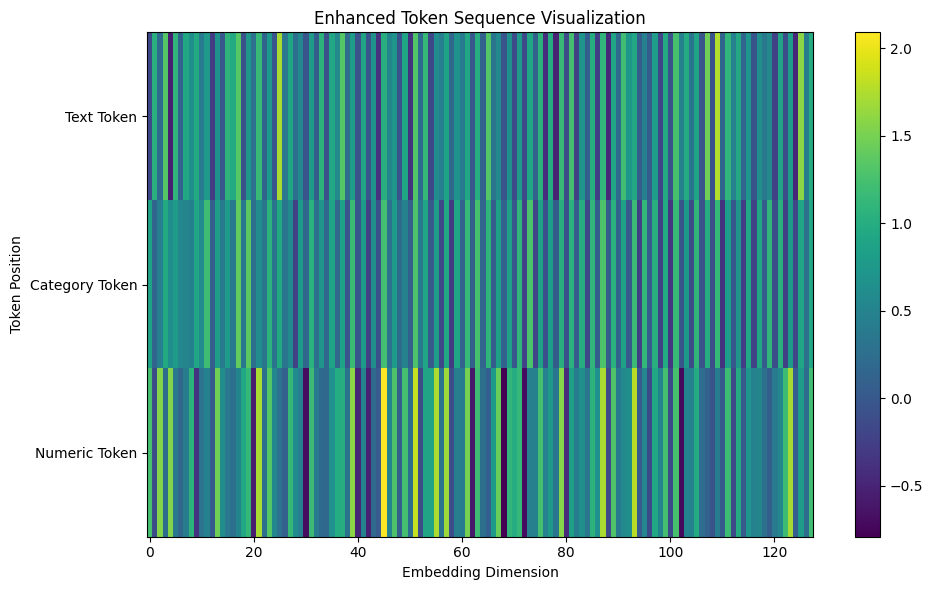

In [11]:
# Cell 7: Enhanced Testing with Transformation Awareness
def visualize_token_sequence(token_sequence, idx=0):
    """
    Visualizes the token sequence for a single example.
    """
    # Get a single example
    example = token_sequence[idx].detach().cpu().numpy()

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(example, aspect='auto', cmap='viridis')

    # Add labels and title
    ax.set_xlabel('Embedding Dimension')
    ax.set_ylabel('Token Position')
    ax.set_title('Enhanced Token Sequence Visualization')
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Text Token', 'Category Token', 'Numeric Token'])

    # Add colorbar
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

print("Creating enhanced input preparation module...")
input_prep = TransformerInputPreparation(d_model=128, transform_info=transform_info)

print("Testing with a single batch...")
start_time = time.time()
test_batch = next(iter(dataloaders['train']))
token_sequence = input_prep(test_batch)
print(f"Processing time: {time.time() - start_time:.2f} seconds")

print(f"Token sequence shape: {token_sequence.shape}")
print(f"  - Batch size: {token_sequence.shape[0]}")
print(f"  - Sequence length: {token_sequence.shape[1]}")
print(f"  - Embedding dimension: {token_sequence.shape[2]}")

# Show target statistics for verification
targets = test_batch['target'].numpy()
print(f"\nTarget statistics (transformed):")
print(f"  - Min: {np.min(targets):.4f}")
print(f"  - Max: {np.max(targets):.4f}")
print(f"  - Mean: {np.mean(targets):.4f}")
print(f"  - Std: {np.std(targets):.4f}")

# Visualize token sequence
print("Visualizing enhanced token sequence...")
visualize_token_sequence(token_sequence)

In [12]:
# Cell 8: Enhanced Processing and Save with Metadata
def process_and_save_tokens(dataloaders, input_prep, output_folder, transform_info, feature_prep):
    """
    Process all data through input preparation and save with enhanced metadata.
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    prepared_data = {}

    for split_name, dataloader in dataloaders.items():
        print(f"Processing {split_name} split...")
        token_sequences = []
        targets = []

        # Process batches with progress bar
        for batch in tqdm(dataloader, desc=f"Processing {split_name}"):
            with torch.no_grad():
                # Prepare input
                token_sequence = input_prep(batch)

                # Move to CPU and convert to numpy for storage
                token_sequences.append(token_sequence.cpu().numpy())
                targets.append(batch['target'].numpy())

        # Concatenate all batches
        prepared_data[split_name] = {
            'token_sequences': np.vstack(token_sequences),
            'targets': np.concatenate(targets)
        }

        print(f"Completed {split_name}: {prepared_data[split_name]['token_sequences'].shape}")

    # Save prepared data with enhanced metadata
    print(f"Saving enhanced prepared data to {output_folder}...")

    # Save main prepared data
    with open(os.path.join(output_folder, 'prepared_tokens.pkl'), 'wb') as f:
        pickle.dump(prepared_data, f)

    # Save transformation info for model training
    with open(os.path.join(output_folder, 'transform_info.pkl'), 'wb') as f:
        pickle.dump(transform_info, f)

    # Save feature prep object for inverse transformations
    with open(os.path.join(output_folder, 'feature_prep.pkl'), 'wb') as f:
        pickle.dump(feature_prep, f)

    print("Enhanced saving complete!")
    print("\nFiles saved:")
    print("  - prepared_tokens.pkl: Token sequences and targets")
    print("  - transform_info.pkl: Transformation metadata")
    print("  - feature_prep.pkl: Feature preparation object for inverse transforms")

    return prepared_data

# Ask user if they want to process and save all data
process_all = input("Do you want to process and save all enhanced data? This may take some time. (y/n): ")

if process_all.lower() == 'y':
    output_folder = "Transformer_Ready_Data_Enhanced"
    prepared_data = process_and_save_tokens(dataloaders, input_prep, output_folder, transform_info, feature_prep)
else:
    print("Skipping full data processing.")

Do you want to process and save all enhanced data? This may take some time. (y/n): y
Processing train split...


Processing train:   0%|          | 0/398 [00:00<?, ?it/s]

Completed train: (50858, 3, 128)
Processing val split...


Processing val:   0%|          | 0/100 [00:00<?, ?it/s]

Completed val: (12715, 3, 128)
Processing test split...


Processing test:   0%|          | 0/125 [00:00<?, ?it/s]

Completed test: (15894, 3, 128)
Saving enhanced prepared data to Transformer_Ready_Data_Enhanced...
Enhanced saving complete!

Files saved:
  - prepared_tokens.pkl: Token sequences and targets
  - transform_info.pkl: Transformation metadata
  - feature_prep.pkl: Feature preparation object for inverse transforms


In [16]:
# Cell 9: 🔧 FIXED - Enhanced Analysis with Transformation Awareness
def analyze_token_embeddings(token_sequence):
    """Analyze the statistical properties of token embeddings."""
    # Get embeddings for each token type
    text_embeddings = token_sequence[:, 0, :]
    category_embeddings = token_sequence[:, 1, :]
    numeric_embeddings = token_sequence[:, 2, :]

    # Compute statistics
    stats = {
        'text': {
            'mean': np.mean(text_embeddings.detach().cpu().numpy()),
            'std': np.std(text_embeddings.detach().cpu().numpy()),
            'min': np.min(text_embeddings.detach().cpu().numpy()),
            'max': np.max(text_embeddings.detach().cpu().numpy())
        },
        'category': {
            'mean': np.mean(category_embeddings.detach().cpu().numpy()),
            'std': np.std(category_embeddings.detach().cpu().numpy()),
            'min': np.min(category_embeddings.detach().cpu().numpy()),
            'max': np.max(category_embeddings.detach().cpu().numpy())
        },
        'numeric': {
            'mean': np.mean(numeric_embeddings.detach().cpu().numpy()),
            'std': np.std(numeric_embeddings.detach().cpu().numpy()),
            'min': np.min(numeric_embeddings.detach().cpu().numpy()),
            'max': np.max(numeric_embeddings.detach().cpu().numpy())
        }
    }

    return stats

# Analyze the token sequence
stats = analyze_token_embeddings(token_sequence)

print("=== Enhanced Token Embedding Statistics ===")
for token_type, token_stats in stats.items():
    print(f"\n{token_type.capitalize()} Token:")
    for stat_name, stat_value in token_stats.items():
        print(f"  {stat_name}: {stat_value:.4f}")

# Create enhanced summary information
print("\n=== Enhanced Transformer Input Summary ===")
print(f"Number of tokens per sequence: {token_sequence.shape[1]}")
print(f"Token embedding dimension: {token_sequence.shape[2]}")
print(f"Input tensor shape for transformer: {token_sequence.shape}")
print("\nToken Descriptions:")
print("1. Text Token: Projected BERT embedding of product name")
print("2. Category Token: Combined projections of main and sub categories")
print("3. Numeric Token: Projected numeric features (prices, ratings, etc.)")

print("\n=== 🔧 FIXED Transformation Pipeline Summary ===")
print(f"Log transformation applied to targets: {transform_info['log_transform']}")
print(f"Target scaling applied: {transform_info['scale_target']} 🔧 (DISABLED)")
# 🔧 FIXED: Removed the problematic target_col reference
print(f"🔧 Target transformation: discount_price → log1p(discount_price)")
print(f"Original price range: ₹{transform_info['original_range'][0]:.2f} - ₹{transform_info['original_range'][1]:.2f}")

# 🔧 FIXED: Show the actual transformation info available
if 'training_targets_range' in transform_info:
    print(f"Training targets range: {transform_info['training_targets_range'][0]:.4f} - {transform_info['training_targets_range'][1]:.4f}")

if 'fix_applied' in transform_info:
    print(f"✅ Fix applied: {transform_info['fix_applied']}")

print("\n=== 🔧 FIXED Important Notes for Model Training ===")
# 🔧 CRITICAL FIX: Updated based on actual transformation applied
target_scaling = transform_info.get('scale_target', False)
log_transform = transform_info.get('log_transform', False)

if log_transform and not target_scaling:
    print("1. Targets are in LOG-TRANSFORMED space only (NO scaling applied) 🔧")
    print("2. This prevents negative values that break inverse transformation")
    print("3. Use custom loss functions (RelativeRMSELoss, LogCoshLoss) for better results")
    print("4. 🔧 FIXED inverse transformation for evaluation:")
    print("   predictions_original = np.expm1(predictions)  # Only log inverse needed")
elif log_transform and target_scaling:
    print("1. Targets are in transformed space (log + scaled)")
    print("2. Use custom loss functions (RelativeRMSELoss, LogCoshLoss) for better results")
    print("3. Remember to inverse-transform predictions for evaluation:")
    print("   predictions_original = np.expm1(feature_prep.inverse_transform_target(predictions))")
elif target_scaling and not log_transform:
    print("1. Targets are in scaled space only")
    print("2. Remember to inverse-transform predictions for evaluation:")
    print("   predictions_original = feature_prep.inverse_transform_target(predictions)")
else:
    print("1. Targets are in original space")
    print("2. No inverse transformation needed")

print("\n🎯 Ready for training with FIXED preprocessing pipeline!")

=== Enhanced Token Embedding Statistics ===

Text Token:
  mean: 0.5274
  std: 0.5385
  min: -0.8344
  max: 1.9587

Category Token:
  mean: 0.5260
  std: 0.4973
  min: -0.4066
  max: 1.4743

Numeric Token:
  mean: 0.5604
  std: 0.8019
  min: -6.6171
  max: 7.9436

=== Enhanced Transformer Input Summary ===
Number of tokens per sequence: 3
Token embedding dimension: 128
Input tensor shape for transformer: torch.Size([128, 3, 128])

Token Descriptions:
1. Text Token: Projected BERT embedding of product name
2. Category Token: Combined projections of main and sub categories
3. Numeric Token: Projected numeric features (prices, ratings, etc.)

=== 🔧 FIXED Transformation Pipeline Summary ===
Log transformation applied to targets: True
Target scaling applied: False 🔧 (DISABLED)
🔧 Target transformation: discount_price → log1p(discount_price)
Original price range: ₹9.00 - ₹371980.00
Training targets range: 2.3026 - 12.8266
✅ Fix applied: Disabled target scaling to prevent negative values

=== 